In [1]:
import glob
import os
import json
import pickle
import yaml

import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import utils_farouk as utils
plt.rcParams.update({"font.size": 20})

/opt/anaconda3/envs/coffea-env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
! ls ../Mar26_2017

DYJetsToLL_Pt-100To250                 QCD_Pt_470to600
DYJetsToLL_Pt-250To400                 QCD_Pt_600to800
DYJetsToLL_Pt-400To650                 QCD_Pt_800to1000
DYJetsToLL_Pt-50To100                  TTTo2L2Nu
DYJetsToLL_Pt-650ToInf                 TTToHadronic
GluGluHToWW_Pt-200ToInf_M-125          TTToSemiLeptonic
HWminusJ_HToWW_M-125                   VBFHToWWToLNuQQ_M-125_withDipoleRecoil
HWplusJ_HToWW_M-125                    WJetsToLNu_HT-100To200
HZJ_HToWW_M-125                        WJetsToLNu_HT-1200To2500
QCD_Pt_1000to1400                      WJetsToLNu_HT-200To400
QCD_Pt_1400to1800                      WJetsToLNu_HT-2500ToInf
QCD_Pt_170to300                        WJetsToLNu_HT-400To600
QCD_Pt_1800to2400                      WJetsToLNu_HT-600To800
QCD_Pt_2400to3200                      WJetsToLNu_HT-70To100
QCD_Pt_300to470                        WJetsToLNu_HT-800To1200
QCD_Pt_3200toInf                       ttHToNonbb_M125


# Event skimmer

In [3]:
presel = {
    "mu": {
#         ### already applied in processor
#         "isolation": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
#         "mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation < 0.2) & (lep_pt >= 55) ) )",
        
        ### checks
#         "lep_fj_dr": "( ( lep_fj_dr>0.03) )"        
#         "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )",
        
    },
    "ele": {
#         ### already applied in processor
#         "isolation": "( ( (lep_pt < 120) & (lep_isolation<0.15)) |  (lep_pt >= 120) )",    
        
        ### checks
#         "lep_fj_dr": "( ( lep_fj_dr>0.03) )"                
#         "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )",  
    }    
}

In [4]:
channels = ["mu", "ele"]
# samples_dir = "../Mar26_2017"

year = "2017"
samples_dir = f"../Apr12_presel_{year}"

samples = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
]

columns = [
    "fj_pt",
    "lep_pt",
    "lep_fj_dr", 
#     "fj_ParT_mass", 
    "fj_minus_lep_m",
#     "rec_higgs_m",
#     "rec_higgs_pt",
    "rec_W_lnu_pt",
    "rec_W_qq_pt",
    "fj_bjets_ophem",
    "fj_bjets",
    "n_bjets_L",
    "n_bjets_M",
    "n_bjets_T",   
    "n_bjets_ophem_L",
    "n_bjets_ophem_M",
    "n_bjets_ophem_T", 
    "lep_met_mt",
    "met_fj_dphi"
#     "lep_isolation",
#     "lep_misolation",
]

In [5]:
events_dict = utils.event_skimmer(year, channels, samples_dir, samples, presel, columns, add_qcd_score=True, add_top_score=True, add_inclusive_score=True)

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 37101 events
tot event weight 58944.13282458637 

Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight

---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the VH dataframe with the remaining 25571 events
tot event weight 27.667197210358843 

ATTENTION: SingleElectron_Run2017C will be skipped
ATTENTION: SingleElectron_Run2017D will be skipped
Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_i

---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 2521 events
tot event weight 37.50489166145864 

Finding QCD_Pt_600to800 samples and should combine them under QCD
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done

Finding QCD_Pt_470to600 samples and should combine them under QCD
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 1990 events
tot event weight 2106.016400790356 

Finding HZJ_HToWW_M-125 samples and should combine them under VH
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weig

---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 532326 events
tot event weight 237787.62232188985 

Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the SingleTop dataframe w

---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the TTbar dataframe with the remaining 928804 events
tot event weight 26256.122782850736 

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the re

Will fill the WJetsLNu dataframe with the remaining 84742 events
tot event weight 98.0802197308765 

Finding ttHToNonbb_M125 samples and should combine them under ttH
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the ttH dataframe with the remaining 20082 events
tot event weight 65.94803920628138 

Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Ap

In [6]:
events_dict.keys()

dict_keys(['mu', 'ele'])

In [7]:
events_dict["mu"].keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttH'])

# Define regions

In [72]:
num_sig, num_bkg = {}, {}
deno_sig, deno_bkg = 0, 0
s, b = 0, 0

tagger_cut = 0.9

# event weights
for sample in ["HWW", "ttH", "VBF", "VH", "TTbar", "QCD", "WJetsLNu", "DYJets"]:
    df_mu = events_dict["mu"][sample]
    df_ele = events_dict["ele"][sample]
    
    # add tagger cut
#     df_mu = df_mu[df_mu["inclusive_score"]>tagger_cut]
#     df_ele = df_ele[df_ele["inclusive_score"]>tagger_cut]
    
    # dR cut
    df_mu = df_mu[df_mu["lep_fj_dr"]<0.03]
    df_ele = df_ele[df_ele["lep_fj_dr"]<0.03]
    
#     df_mu = df_mu[np.abs(df_mu["met_fj_dphi"])<2]
#     df_ele = df_ele[np.abs(df_ele["met_fj_dphi"])<2]    
    
    
    ### WJetsLNu
    # 1. golden variable
#     cut_mu = (df_mu["rec_W_lnu_pt"]/df_mu["rec_W_qq_pt"])>4.8
#     cut_ele = (df_ele["rec_W_lnu_pt"]/df_ele["rec_W_qq_pt"])>4.8
    
    # 1.1. golden variable plus kill ttbar
#     cut_mu = ((df_mu["rec_W_lnu_pt"]/df_mu["rec_W_qq_pt"])>4.8) & (df_mu["n_bjets_M"]<1)
#     cut_ele = ((df_ele["rec_W_lnu_pt"]/df_ele["rec_W_qq_pt"])>4.8) & (df_ele["n_bjets_M"]<1)
    
    # 2. mT
#     cut_mu = df_mu["lep_met_mt"]<200
#     cut_ele = df_ele["lep_met_mt"]<200
    
    ### TTbar
    # 1. nbjets>=1
    cut_mu = (df_mu["n_bjets_M"]>-1)
    cut_ele = (df_ele["n_bjets_M"]>-1)

#     cut_mu = (df_mu["n_bjets_M"]>=1)
#     cut_ele = (df_ele["n_bjets_M"]>=1)
        
    
    # 1.1 nbjets>=1 plus kill ttH
#     cut_mu = (df_mu["n_bjets_M"]>=1) & (df_mu["lep_fj_dr"]<0.001)
#     cut_ele = (df_ele["n_bjets_M"]>=1) & (df_ele["lep_fj_dr"]<0.001)
    

    # playground
#     cut_mu = ((df_mu["rec_W_lnu_pt"]/df_mu["rec_W_qq_pt"])>4.8) & (df_mu["n_bjets_M"]>=2) # & (df_mu["n_bjets_T"]>=2)
#     cut_ele = ((df_ele["rec_W_lnu_pt"]/df_ele["rec_W_qq_pt"])>4.8) & (df_ele["n_bjets_M"]>=2) # & (df_ele["n_bjets_T"]>=1)
                  
#     iso_mu = ( ( (df_mu["lep_pt"] < 55) & (df_mu["lep_isolation"]>0.15)) |  (df_mu["lep_pt"] >= 55) )
#     iso_ele = ( ( (df_ele["lep_pt"] < 120) & (df_ele["lep_isolation"]>0.15)) |  (df_ele["lep_pt"] >= 120) )
#     miso_mu = ( ( (df_mu["lep_pt"] < 55) & (df_mu["lep_misolation"]>0.2)) |  (df_mu["lep_pt"] >= 55) )
        
#     cut_mu = (df_mu["fj_bjets"]<0.3) & iso_mu & miso_mu
#     cut_ele = (df_ele["fj_bjets"]<0.3) & iso_ele
#     cut_mu = (df_mu["n_bjets_M"]<2) & (df_mu["lep_fj_dr"]>0.03)
#     cut_ele = (df_ele["n_bjets_M"]<2) & (df_ele["lep_fj_dr"]>0.03)

        
    # add selected cut
    df_mu = df_mu[cut_mu]
    df_ele = df_ele[cut_ele]
    
    ##############################    
    if sample in utils.signals:
        num_sig[sample] = df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
        deno_sig += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
    else:
        num_bkg[sample] = df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
        deno_bkg += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()

if tagger_cut !=0 :
#     print(f"AFTER TAGGER CUT > {tagger_cut}")
    print(f"BEFORE TAGGER CUT")

print(rf"s/sqrt(b): {deno_sig/math.sqrt(deno_bkg):.2f}")
print("------------------------")
print(f"Signal: {deno_sig:.2f}")
num_sig["ggF"] = num_sig.pop("HWW")
for sample in num_sig:
    print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")
print("------------------------")
print(f"Background: {deno_bkg:.2f}")
for sample in num_bkg:
    print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")  

BEFORE TAGGER CUT
s/sqrt(b): 0.07
------------------------
Signal: 75.80
- ttH: 19%
- VBF: 9%
- VH: 47%
- ggF: 26%
------------------------
Background: 1098083.40
- TTbar: 5%
- QCD: 29%
- WJetsLNu: 55%
- DYJets: 10%


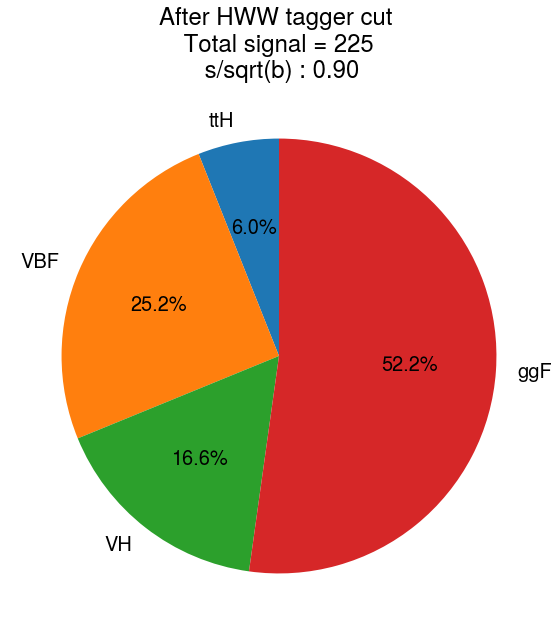

In [61]:
plt.rcParams.update({"font.size": 20})

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))
# Create the pie chart

patches, texts, autotexts = ax.pie(num_sig.values(), labels=num_sig.keys(), autopct='%1.1f%%', startangle=90)
for text in texts:
    text.set_size(20)
for autotext in autotexts:
    autotext.set_color('black')
    
    
# Add a title
plt.title(f"After HWW tagger cut \n Total signal = {sum(list(num_sig.values())):.0f} \n s/sqrt(b) : {deno_sig/math.sqrt(deno_bkg):.2f}")

# Display the chart
plt.show()

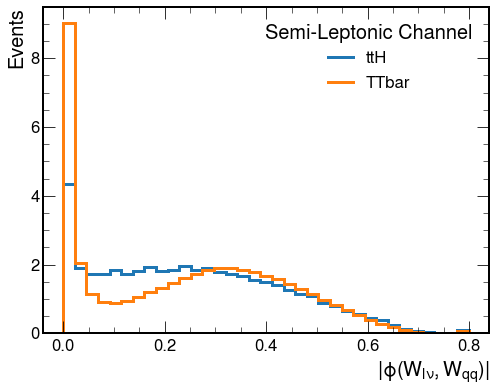

In [99]:
plt.rcParams.update({"font.size": 20})
# make simple 1d-histogram of `jet-lep mass`
var = "lep_fj_dr"

channels = ["mu", "ele"]

samples = ["ttH", "TTbar"]

fig, ax = plt.subplots(figsize=(8, 6))
for sample in samples:

    h = hist2.Hist(
        hist2.axis.Regular(35, 0, 0.8, name="var", label=r"|$\phi(W_{l\nu},W_{qq})$|", overflow=True),
    )
    for ch in channels:
        h.fill(
            var=np.abs(events_dict[ch][sample][var]),
            weight=events_dict[ch][sample]["event_weight"]
        )

    hep.histplot(
        h,
        ax=ax,
        label=f"{sample}",
        linewidth=3,
        density=True
    )
     
ax.set_ylim(0)
if len(channels)==2:
    ax.legend(title=f"Semi-Leptonic Channel")
else:
    ax.legend(title=f"{data_label[ch]} Channel")
ax.set_ylabel("Events");

# s/b: dR(Jet,Lep)

In [136]:
channels = ["mu", "ele"]

dr_cuts = [0, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

s, b = {}, {}
for b4_or_af in ["After tagger", "Before tagger"]:
    s[b4_or_af], b[b4_or_af] = {}, {}
    for dr_cut in dr_cuts:
        if dr_cut == 0:
            cut_label = f"pre-selection"
        else:
            cut_label = f"pre-selection + dR(Jet,Lep)>{dr_cut:.2f}"

        s[b4_or_af][cut_label], b[b4_or_af][cut_label] = 0, 0

        for ch in channels:   # sum over channels
            for sample in events_dict[ch]:
                df = events_dict[ch][sample]

                ### apply tagger cut
                if b4_or_af == "After tagger":
                    keep = ( df["inclusive_score"]>0.9 )
                    df = df.loc[keep, :]

                keep = ( df["lep_fj_dr"]>dr_cut )
                df = df.loc[keep, :]            

                ### mass window
                regressed_mass = df["fj_ParT_mass"]     
                fj_minus_lep_mass = df["fj_minus_lep_m"]     
        #         mass_window = (regressed_mass>100) & (regressed_mass<150)
                mass_window = (fj_minus_lep_mass>0) & (fj_minus_lep_mass<150)

                ### s/b
                ev_weight = df["event_weight"]        
                if sample in utils.signals:
                    s[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                else:
                    b[b4_or_af][cut_label] += ev_weight[mass_window].sum()    
                    
for b4_or_af in ["Before tagger", "After tagger"]:
    print(f"{b4_or_af} cut:")
    for dr_cut in s[b4_or_af]:
        print(f"{dr_cut} : s/b = {s[b4_or_af][dr_cut]/math.sqrt(b[b4_or_af][dr_cut]):.3f}")
    print("-----------------------")                    

Before tagger cut:
pre-selection : s/b = 0.459
pre-selection + dR(Jet,Lep)>0.01 : s/b = 0.583
pre-selection + dR(Jet,Lep)>0.02 : s/b = 0.609
pre-selection + dR(Jet,Lep)>0.03 : s/b = 0.641
pre-selection + dR(Jet,Lep)>0.04 : s/b = 0.653
pre-selection + dR(Jet,Lep)>0.05 : s/b = 0.656
pre-selection + dR(Jet,Lep)>0.06 : s/b = 0.650
pre-selection + dR(Jet,Lep)>0.07 : s/b = 0.638
pre-selection + dR(Jet,Lep)>0.08 : s/b = 0.622
pre-selection + dR(Jet,Lep)>0.09 : s/b = 0.607
pre-selection + dR(Jet,Lep)>0.10 : s/b = 0.590
-----------------------
After tagger cut:
pre-selection : s/b = 0.710
pre-selection + dR(Jet,Lep)>0.01 : s/b = 0.934
pre-selection + dR(Jet,Lep)>0.02 : s/b = 0.937
pre-selection + dR(Jet,Lep)>0.03 : s/b = 0.939
pre-selection + dR(Jet,Lep)>0.04 : s/b = 0.930
pre-selection + dR(Jet,Lep)>0.05 : s/b = 0.914
pre-selection + dR(Jet,Lep)>0.06 : s/b = 0.902
pre-selection + dR(Jet,Lep)>0.07 : s/b = 0.879
pre-selection + dR(Jet,Lep)>0.08 : s/b = 0.853
pre-selection + dR(Jet,Lep)>0.09 : s/

# s/b: pT(Jet)/pT(Lep)

In [392]:
channels = ["mu", "ele"]

cuts = [1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3]

s, b = {}, {}
for b4_or_af in ["After tagger"]:
    s[b4_or_af], b[b4_or_af] = {}, {}
    for cut in cuts:
        if cut == 1:
            cut_label = f"pre-selection"
        else:
            cut_label = f"pre-selection + pT(rec_higgs)/pT(Lep)>{cut:.2f}"

        s[b4_or_af][cut_label], b[b4_or_af][cut_label] = 0, 0

        for ch in channels:   # sum over channels
            for sample in events_dict[ch]:
                df = events_dict[ch][sample]

                ### apply tagger cut
                if b4_or_af == "After tagger":
                    keep = ( df["inclusive_score"]>0.9 )
                    df = df.loc[keep, :]
                    
#                 keep = (  df["fj_pt"]/df["lep_pt"]>cut )
                keep = (  df["rec_higgs_pt"]/df["lep_pt"]>cut )
                
                df = df.loc[keep, :]            

                ### mass window
                regressed_mass = df["fj_ParT_mass"]     
                fj_minus_lep_mass = df["fj_minus_lep_m"]     
        #         mass_window = (regressed_mass>100) & (regressed_mass<150)
                mass_window = (fj_minus_lep_mass>0) & (fj_minus_lep_mass<150)

                ### s/b
                ev_weight = df["event_weight"]        
                if sample in utils.signals:
                    s[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                else:
                    b[b4_or_af][cut_label] += ev_weight[mass_window].sum()    

for b4_or_af in ["After tagger"]:
    print(f"{b4_or_af} cut:")
    for cut in s[b4_or_af]:
        print(f"{cut} : s/b = {s[b4_or_af][cut]/math.sqrt(b[b4_or_af][cut]):.3f}")
    print("-----------------------")                    

After tagger cut:
pre-selection : s/b = 0.717
pre-selection + pT(rec_higgs)/pT(Lep)>1.20 : s/b = 0.776
pre-selection + pT(rec_higgs)/pT(Lep)>1.40 : s/b = 0.845
pre-selection + pT(rec_higgs)/pT(Lep)>1.60 : s/b = 0.869
pre-selection + pT(rec_higgs)/pT(Lep)>1.80 : s/b = 0.845
pre-selection + pT(rec_higgs)/pT(Lep)>2.00 : s/b = 0.801
pre-selection + pT(rec_higgs)/pT(Lep)>2.20 : s/b = 0.752
pre-selection + pT(rec_higgs)/pT(Lep)>2.40 : s/b = 0.702
pre-selection + pT(rec_higgs)/pT(Lep)>2.60 : s/b = 0.654
pre-selection + pT(rec_higgs)/pT(Lep)>2.80 : s/b = 0.616
pre-selection + pT(rec_higgs)/pT(Lep)>3.00 : s/b = 0.579
-----------------------


# s/b: bjet

In [34]:
channels = ["mu", "ele"]

cuts = [9999999999, 0.0532, 0.3040, 0.7476]

s, b = {}, {}
for b4_or_af in ["After tagger", "Before tagger"]:
    s[b4_or_af], b[b4_or_af] = {}, {}
    for cut in cuts:
        if cut == 9999999999:
            cut_label = f"pre-selection"
        else:
            cut_label = f"pre-selection + btag_ophem<{cut:.2f}"

        s[b4_or_af][cut_label], b[b4_or_af][cut_label] = 0, 0

        for ch in channels:   # sum over channels
            for sample in events_dict[ch]:
                df = events_dict[ch][sample]
    
#                 # force dR cut
#                 df = df[df["lep_fj_dr"]>0.03]
                
                ### apply tagger cut
                if b4_or_af == "After tagger":
                    keep = ( df["inclusive_score"]>0.9 )
                    df = df.loc[keep, :]

                keep = ( df["fj_bjets_ophem"]<cut )
                df = df.loc[keep, :]            

                ### mass window
                regressed_mass = df["fj_ParT_mass"]     
                fj_minus_lep_mass = df["fj_minus_lep_m"]     
        #         mass_window = (regressed_mass>100) & (regressed_mass<150)
                mass_window = (fj_minus_lep_mass>0) & (fj_minus_lep_mass<150)

                ### s/b
                ev_weight = df["event_weight"]        
                if sample in utils.signals:
                    s[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                else:
                    b[b4_or_af][cut_label] += ev_weight[mass_window].sum()    

for b4_or_af in ["Before tagger", "After tagger"]:
    print(f"{b4_or_af} cut:")
    for cut in s[b4_or_af]:
        print(f"{cut} : s/b = {s[b4_or_af][cut]/math.sqrt(b[b4_or_af][cut]):.3f}")
    print("-----------------------")                   

Before tagger cut:
pre-selection : s/b = 0.636
pre-selection + btag_ophem<0.05 : s/b = 0.483
pre-selection + btag_ophem<0.30 : s/b = 0.575
pre-selection + btag_ophem<0.75 : s/b = 0.601
-----------------------
After tagger cut:
pre-selection : s/b = 0.930
pre-selection + btag_ophem<0.05 : s/b = 0.715
pre-selection + btag_ophem<0.30 : s/b = 0.842
pre-selection + btag_ophem<0.75 : s/b = 0.878
-----------------------


In [35]:
channels = ["mu", "ele"]

cuts = [9999999999, 0.0532, 0.3040, 0.7476]

s, b = {}, {}
for b4_or_af in ["After tagger", "Before tagger"]:
    s[b4_or_af], b[b4_or_af] = {}, {}
    for cut in cuts:
        if cut == 9999999999:
            cut_label = f"pre-selection"
        else:
            cut_label = f"pre-selection + btag<{cut:.2f}"

        s[b4_or_af][cut_label], b[b4_or_af][cut_label] = 0, 0

        for ch in channels:   # sum over channels
            for sample in events_dict[ch]:
                df = events_dict[ch][sample]
                
                # force dR cut
                df = df[df["lep_fj_dr"]>0.03]

                ### apply tagger cut
                if b4_or_af == "After tagger":
                    keep = ( df["inclusive_score"]>0.9 )
                    df = df.loc[keep, :]

                keep = ( df["fj_bjets"]<cut )
                df = df.loc[keep, :]            

                ### mass window
                regressed_mass = df["fj_ParT_mass"]     
                fj_minus_lep_mass = df["fj_minus_lep_m"]     
        #         mass_window = (regressed_mass>100) & (regressed_mass<150)
                mass_window = (fj_minus_lep_mass>0) & (fj_minus_lep_mass<150)

                ### s/b
                ev_weight = df["event_weight"]        
                if sample in utils.signals:
                    s[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                else:
                    b[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                    
for b4_or_af in ["Before tagger", "After tagger"]:
    print(f"{b4_or_af} cut:")
    for cut in s[b4_or_af]:
        print(f"{cut} : s/b = {s[b4_or_af][cut]/math.sqrt(b[b4_or_af][cut]):.3f}")
    print("-----------------------")                    

Before tagger cut:
pre-selection : s/b = 0.637
pre-selection + btag<0.05 : s/b = 0.466
pre-selection + btag<0.30 : s/b = 0.566
pre-selection + btag<0.75 : s/b = 0.594
-----------------------
After tagger cut:
pre-selection : s/b = 0.932
pre-selection + btag<0.05 : s/b = 0.699
pre-selection + btag<0.30 : s/b = 0.837
pre-selection + btag<0.75 : s/b = 0.875
-----------------------


# s/b: nbjets

In [120]:
samples_ = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
#     "QCD",
#     "DYJets",
#     "WJetsLNu",
#     "WZQQ",
    "TTbar",
#     "SingleTop",
#     "Diboson",
]


#     "n_bjets_L",
#     "n_bjets_M",
#     "n_bjets_T",   
#     "n_bjets_ophem_L",
#     "n_bjets_ophem_M",
#     "n_bjets_ophem_T",  
    
channels = ["mu", "ele"]

cuts = [0, 1, 2, 3, 4]

s, b = {}, {}
for b4_or_af in ["After tagger"]:
    s[b4_or_af], b[b4_or_af] = {}, {}
    for cut in cuts:
        if cut == 0:
            cut_label = f"pre-selection"
        else:
            cut_label = f"pre-selection + n_bjets_ophem_M>={cut}"

        s[b4_or_af][cut_label], b[b4_or_af][cut_label] = 0, 0

        for ch in channels:   # sum over channels
            for sample in events_dict[ch]:
#                 if sample not in samples_:
#                     continue
                df = events_dict[ch][sample]
                
                # force dR cut
#                 df = df[df["lep_fj_dr"]>0.03]

                ### apply tagger cut
                if b4_or_af == "After tagger":
                    keep = ( df["inclusive_score"]>0.9 )
                    df = df.loc[keep, :]
                
                if cut != 0:
                    keep = ( df["n_bjets_ophem_M"]>=cut )
                    df = df.loc[keep, :]            

                ### mass window
                regressed_mass = df["fj_ParT_mass"]     
                fj_minus_lep_mass = df["fj_minus_lep_m"]     
        #         mass_window = (regressed_mass>100) & (regressed_mass<150)
                mass_window = (fj_minus_lep_mass>0) & (fj_minus_lep_mass<150)

                ### s/b
                ev_weight = df["event_weight"]        
#                 if sample in utils.signals:
                if sample in ["TTbar"]:                    
                    s[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                else:
                    b[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                    
for b4_or_af in ["After tagger"]:
    print(f"{b4_or_af} cut:")
    for cut in s[b4_or_af]:
        print(f"{cut} : s/b = {s[b4_or_af][cut]/math.sqrt(b[b4_or_af][cut]):.3f}")
    print("-----------------------")                        

After tagger cut:
pre-selection : s/b = 32.592
pre-selection + n_bjets_ophem_M>=1 : s/b = 72.627
pre-selection + n_bjets_ophem_M>=2 : s/b = 46.617
pre-selection + n_bjets_ophem_M>=3 : s/b = 14.166
pre-selection + n_bjets_ophem_M>=4 : s/b = 3.305
-----------------------


In [128]:
samples_ = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
#     "QCD",
#     "DYJets",
#     "WJetsLNu",
#     "WZQQ",
    "TTbar",
#     "SingleTop",
#     "Diboson",
]


#     "n_bjets_L",
#     "n_bjets_M",
#     "n_bjets_T",   
#     "n_bjets_ophem_L",
#     "n_bjets_ophem_M",
#     "n_bjets_ophem_T",  
    
channels = ["mu", "ele"]

cuts = [0, 1, 2, 3, 4]

s, b = {}, {}
for b4_or_af in ["After tagger", "Before tagger"]:
    s[b4_or_af], b[b4_or_af] = {}, {}
    for cut in cuts:
        if cut == 0:
            cut_label = f"pre-selection"
        else:
            cut_label = f"pre-selection + n_bjets_M<{cut}"

        s[b4_or_af][cut_label], b[b4_or_af][cut_label] = 0, 0

        for ch in channels:   # sum over channels
            for sample in events_dict[ch]:
                if sample not in samples_:
                    continue
                df = events_dict[ch][sample]
                
                # force dR cut
#                 df = df[df["lep_fj_dr"]>0.03]

                ### apply tagger cut
                if b4_or_af == "After tagger":
                    keep = ( df["inclusive_score"]>0.9 )
                    df = df.loc[keep, :]
                
                if cut != 0:
                    keep = ( df["n_bjets_M"]<cut )
                    df = df.loc[keep, :]            

                ### mass window
                regressed_mass = df["fj_ParT_mass"]     
                fj_minus_lep_mass = df["fj_minus_lep_m"]     
        #         mass_window = (regressed_mass>100) & (regressed_mass<150)
                mass_window = (fj_minus_lep_mass>0) & (fj_minus_lep_mass<150)

                ### s/b
                ev_weight = df["event_weight"]        
                if sample in utils.signals:
                    s[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                else:
                    b[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                    
for b4_or_af in ["Before tagger", "After tagger"]:
    print(f"{b4_or_af} cut:")
    for cut in s[b4_or_af]:
        print(f"{cut} : s/b = {s[b4_or_af][cut]/math.sqrt(b[b4_or_af][cut]):.3f}")
    print("-----------------------")                        

Before tagger cut:
pre-selection : s/b = 1.209
pre-selection + n_bjets_M<1 : s/b = 1.799
pre-selection + n_bjets_M<2 : s/b = 1.237
pre-selection + n_bjets_M<3 : s/b = 1.209
pre-selection + n_bjets_M<4 : s/b = 1.209
-----------------------
After tagger cut:
pre-selection : s/b = 2.365
pre-selection + n_bjets_M<1 : s/b = 4.452
pre-selection + n_bjets_M<2 : s/b = 2.670
pre-selection + n_bjets_M<3 : s/b = 2.381
pre-selection + n_bjets_M<4 : s/b = 2.366
-----------------------


# s/b: golden variable

In [171]:
np.linspace(0,4,21)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ])

In [192]:
channels = ["mu", "ele"]

# cuts = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
cuts = np.linspace(0,1,21)

s, b = {}, {}
for b4_or_af in ["After tagger", "Before tagger"]:
    s[b4_or_af], b[b4_or_af] = {}, {}
    for cut in cuts:
        if cut == 0:
            cut_label = f"pre-selection"
        else:
            cut_label = f"pre-selection + pT(W(lnu)/pT(Wqq)>{cut:.2f}"

        s[b4_or_af][cut_label], b[b4_or_af][cut_label] = 0, 0

        for ch in channels:   # sum over channels
            for sample in events_dict[ch]:
                df = events_dict[ch][sample]

                ### apply tagger cut
                if b4_or_af == "After tagger":
                    keep = ( df["inclusive_score"]>0.9 )
                    df = df.loc[keep, :]

                if cut != 0:                    
                    keep = (  df["rec_W_lnu_pt"]/df["rec_W_qq_pt"]>cut )                
                    df = df.loc[keep, :]            

                ### mass window
                regressed_mass = df["fj_ParT_mass"]     
                fj_minus_lep_mass = df["fj_minus_lep_m"]     
        #         mass_window = (regressed_mass>100) & (regressed_mass<150)
                mass_window = (fj_minus_lep_mass>0) & (fj_minus_lep_mass<150)

                ### s/b
                ev_weight = df["event_weight"]        
                if sample in utils.signals:
                    s[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                else:
                    b[b4_or_af][cut_label] += ev_weight[mass_window].sum()    
                    
for b4_or_af in ["Before tagger", "After tagger"]:
    print(f"{b4_or_af} cut:")
    for cut in s[b4_or_af]:
        print(f"{cut} : s/b = {s[b4_or_af][cut]/math.sqrt(b[b4_or_af][cut]):.3f}")
    print("-----------------------")

Before tagger cut:
pre-selection : s/b = 0.459
pre-selection + pT(W(lnu)/pT(Wqq)>0.05 : s/b = 0.458
pre-selection + pT(W(lnu)/pT(Wqq)>0.10 : s/b = 0.456
pre-selection + pT(W(lnu)/pT(Wqq)>0.15 : s/b = 0.453
pre-selection + pT(W(lnu)/pT(Wqq)>0.20 : s/b = 0.449
pre-selection + pT(W(lnu)/pT(Wqq)>0.25 : s/b = 0.443
pre-selection + pT(W(lnu)/pT(Wqq)>0.30 : s/b = 0.436
pre-selection + pT(W(lnu)/pT(Wqq)>0.35 : s/b = 0.428
pre-selection + pT(W(lnu)/pT(Wqq)>0.40 : s/b = 0.418
pre-selection + pT(W(lnu)/pT(Wqq)>0.45 : s/b = 0.408
pre-selection + pT(W(lnu)/pT(Wqq)>0.50 : s/b = 0.397
pre-selection + pT(W(lnu)/pT(Wqq)>0.55 : s/b = 0.387
pre-selection + pT(W(lnu)/pT(Wqq)>0.60 : s/b = 0.375
pre-selection + pT(W(lnu)/pT(Wqq)>0.65 : s/b = 0.364
pre-selection + pT(W(lnu)/pT(Wqq)>0.70 : s/b = 0.352
pre-selection + pT(W(lnu)/pT(Wqq)>0.75 : s/b = 0.341
pre-selection + pT(W(lnu)/pT(Wqq)>0.80 : s/b = 0.329
pre-selection + pT(W(lnu)/pT(Wqq)>0.85 : s/b = 0.317
pre-selection + pT(W(lnu)/pT(Wqq)>0.90 : s/b = 0.306

In [194]:
channels = ["mu", "ele"]

# cuts = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
cuts = np.linspace(0,4,21)

s, b = {}, {}
for b4_or_af in ["After tagger", "Before tagger"]:
    s[b4_or_af], b[b4_or_af] = {}, {}
    for cut in cuts:
        if cut == 0:
            cut_label = f"pre-selection"
        else:
            cut_label = f"pre-selection + pT(W(lnu)/pT(Wqq)<{cut:.2f}"

        s[b4_or_af][cut_label], b[b4_or_af][cut_label] = 0, 0

        for ch in channels:   # sum over channels
            for sample in events_dict[ch]:
                df = events_dict[ch][sample]

                ### apply tagger cut
                if b4_or_af == "After tagger":
                    keep = ( df["inclusive_score"]>0.9 )
                    df = df.loc[keep, :]

                if cut != 0:
                    keep = ( df["rec_W_lnu_pt"]/df["rec_W_qq_pt"]<cut )# & (  df["rec_W_lnu_pt"]/df["rec_W_qq_pt"]>0.2 )
                    df = df.loc[keep, :]            

                ### mass window
                regressed_mass = df["fj_ParT_mass"]     
                fj_minus_lep_mass = df["fj_minus_lep_m"]     
        #         mass_window = (regressed_mass>100) & (regressed_mass<150)
                mass_window = (fj_minus_lep_mass>0) & (fj_minus_lep_mass<150)

                ### s/b
                ev_weight = df["event_weight"]        
                if sample in utils.signals:
                    s[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                else:
                    b[b4_or_af][cut_label] += ev_weight[mass_window].sum()    
                    
for b4_or_af in ["Before tagger", "After tagger"]:
    print(f"{b4_or_af} cut:")
    for cut in s[b4_or_af]:
        print(f"{cut} : s/b = {s[b4_or_af][cut]/math.sqrt(b[b4_or_af][cut]):.3f}")
    print("-----------------------")

Before tagger cut:
pre-selection : s/b = 0.459
pre-selection + pT(W(lnu)/pT(Wqq)<0.20 : s/b = 0.101
pre-selection + pT(W(lnu)/pT(Wqq)<0.40 : s/b = 0.207
pre-selection + pT(W(lnu)/pT(Wqq)<0.60 : s/b = 0.302
pre-selection + pT(W(lnu)/pT(Wqq)<0.80 : s/b = 0.380
pre-selection + pT(W(lnu)/pT(Wqq)<1.00 : s/b = 0.438
pre-selection + pT(W(lnu)/pT(Wqq)<1.20 : s/b = 0.480
pre-selection + pT(W(lnu)/pT(Wqq)<1.40 : s/b = 0.508
pre-selection + pT(W(lnu)/pT(Wqq)<1.60 : s/b = 0.525
pre-selection + pT(W(lnu)/pT(Wqq)<1.80 : s/b = 0.537
pre-selection + pT(W(lnu)/pT(Wqq)<2.00 : s/b = 0.544
pre-selection + pT(W(lnu)/pT(Wqq)<2.20 : s/b = 0.547
pre-selection + pT(W(lnu)/pT(Wqq)<2.40 : s/b = 0.548
pre-selection + pT(W(lnu)/pT(Wqq)<2.60 : s/b = 0.547
pre-selection + pT(W(lnu)/pT(Wqq)<2.80 : s/b = 0.547
pre-selection + pT(W(lnu)/pT(Wqq)<3.00 : s/b = 0.545
pre-selection + pT(W(lnu)/pT(Wqq)<3.20 : s/b = 0.543
pre-selection + pT(W(lnu)/pT(Wqq)<3.40 : s/b = 0.540
pre-selection + pT(W(lnu)/pT(Wqq)<3.60 : s/b = 0.536

# s/b: mT

In [19]:
channels = ["mu", "ele"]

# cuts = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
cuts = np.linspace(0,400,41)

s, b = {}, {}
for b4_or_af in ["After tagger", "Before tagger"]:
    s[b4_or_af], b[b4_or_af] = {}, {}
    for cut in cuts:
        if cut == 0:
            cut_label = f"pre-selection"
        else:
            cut_label = f"pre-selection + mT<{cut:.2f}"

        s[b4_or_af][cut_label], b[b4_or_af][cut_label] = 0, 0

        for ch in channels:   # sum over channels
            for sample in events_dict[ch]:
                df = events_dict[ch][sample]

                ### apply tagger cut
                if b4_or_af == "After tagger":
                    keep = ( df["inclusive_score"]>0.9 )
                    df = df.loc[keep, :]

                if cut != 0:
                    keep = ( df["lep_met_mt"]<cut )# & (  df["rec_W_lnu_pt"]/df["rec_W_qq_pt"]>0.2 )
                    df = df.loc[keep, :]            

                ### mass window
                regressed_mass = df["fj_ParT_mass"]     
                fj_minus_lep_mass = df["fj_minus_lep_m"]     
        #         mass_window = (regressed_mass>100) & (regressed_mass<150)
                mass_window = (fj_minus_lep_mass>0) & (fj_minus_lep_mass<150)

                ### s/b
                ev_weight = df["event_weight"]        
                if sample in utils.signals:
                    s[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                else:
                    b[b4_or_af][cut_label] += ev_weight[mass_window].sum()    
                    
for b4_or_af in ["Before tagger", "After tagger"]:
    print(f"{b4_or_af} cut:")
    for cut in s[b4_or_af]:
        print(f"{cut} : s/b = {s[b4_or_af][cut]/math.sqrt(b[b4_or_af][cut]):.3f}")
    print("-----------------------")

Before tagger cut:
pre-selection : s/b = 0.459
pre-selection + mT<10.00 : s/b = 0.144
pre-selection + mT<20.00 : s/b = 0.208
pre-selection + mT<30.00 : s/b = 0.252
pre-selection + mT<40.00 : s/b = 0.291
pre-selection + mT<50.00 : s/b = 0.324
pre-selection + mT<60.00 : s/b = 0.351
pre-selection + mT<70.00 : s/b = 0.376
pre-selection + mT<80.00 : s/b = 0.394
pre-selection + mT<90.00 : s/b = 0.409
pre-selection + mT<100.00 : s/b = 0.422
pre-selection + mT<110.00 : s/b = 0.430
pre-selection + mT<120.00 : s/b = 0.437
pre-selection + mT<130.00 : s/b = 0.441
pre-selection + mT<140.00 : s/b = 0.444
pre-selection + mT<150.00 : s/b = 0.446
pre-selection + mT<160.00 : s/b = 0.447
pre-selection + mT<170.00 : s/b = 0.448
pre-selection + mT<180.00 : s/b = 0.449
pre-selection + mT<190.00 : s/b = 0.449
pre-selection + mT<200.00 : s/b = 0.449
pre-selection + mT<210.00 : s/b = 0.450
pre-selection + mT<220.00 : s/b = 0.450
pre-selection + mT<230.00 : s/b = 0.450
pre-selection + mT<240.00 : s/b = 0.451
pr

# Optimum finding algorithm

In [12]:
from tqdm.notebook import tqdm
def get_optimum_s_over_b(vars_, steps, apply_tagger=False):
    """
    Idea: given a range, fix the lower limit and do a "for loop" where you slide the upper limit to the left until 
    you hit the lower limit. Then increase the lower limit by one step and repeat.
    
    NOTE: for computational costs, and assuming the steps are always about a nice gaussian;
    the lower limit does not bypass the midpoint.
    """

    s, b = {}, {}
    
    midpoint = steps.mean()
    for low in tqdm(steps):
        if low>midpoint:
            break
        for high in tqdm(steps):
            if high<=low:
                continue
        
            s[f"{low:.2f}-{high:.2f}"], b[f"{low:.2f}-{high:.2f}"] = 0, 0
        
            for ch in channels:   # sum over channels
                for sample in events_dict[ch]:
                    df = events_dict[ch][sample]

                    ### apply tagger cut
                    if apply_tagger:
                        keep = ( df["inclusive_score"]>0.9 )
                        df = df.loc[keep, :]

                    # selection
                    if len(vars_)==2:
                        keep = ( df[vars_[0]]/df[vars_[1]]>low ) & ( df[vars_[0]]/df[vars_[1]]<high ) 
                    else:
                        keep = ( df[vars_[0]]>low ) & ( df[vars_[0]]<high )
    
                    df = df.loc[keep, :]            

                    ### mass window
                    mass_window = (df["fj_minus_lep_m"]>0) & (df["fj_minus_lep_m"]<150)

                    ### s/b
                    ev_weight = df["event_weight"]        
                    if sample in utils.signals:
                        s[f"{low:.2f}-{high:.2f}"] += ev_weight[mass_window].sum()
                    else:
                        b[f"{low:.2f}-{high:.2f}"] += ev_weight[mass_window].sum()   
         
    max_ = 0
    for range_ in s:
        s_over_b = s[range_]/np.sqrt(b[range_])
        if s_over_b >= max_:
            max_ = s_over_b
    
    for range_ in s:
        s_over_b = s[range_]/np.sqrt(b[range_])
        if s_over_b >= max_:
            print(f"{range_} : {s[range_]/np.sqrt(b[range_]):.2f}")    
        
    return s, b

# dR(Jet,Lepton)

In [314]:
steps = np.linspace(0, 0.8, 41)
steps 

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 ])

In [315]:
s, b = get_optimum_s_over_b(["lep_fj_dr"], steps, apply_tagger=True)

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

0.02-0.36 : 0.96


# pT(Jet)/pT(Lepton)

In [324]:
steps = np.linspace(0, 10, 41)
steps 

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  ])

In [318]:
s, b = get_optimum_s_over_b(["fj_pt", "lep_pt"], steps, apply_tagger=True)

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

1.25-10.00 : 0.92


<ipython-input-313-b011f9fa9f87>:52: RuntimeWarning: invalid value encountered in double_scalars
  s_over_b = s[range_]/np.sqrt(b[range_])
<ipython-input-313-b011f9fa9f87>:57: RuntimeWarning: invalid value encountered in double_scalars
  s_over_b = s[range_]/np.sqrt(b[range_])


In [326]:
steps = np.linspace(0, 10, 41)
steps 

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  ])

# pT(W_lnu)/pT(W_qq)

In [328]:
steps = np.linspace(0, 10, 41)
steps

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  ])

In [327]:
s, b = get_optimum_s_over_b(["rec_W_lnu_pt", "rec_W_qq_pt"], steps, apply_tagger=True)

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

0.25-3.50 : 0.92


# mT

In [13]:
steps = np.linspace(0, 200, 41)
steps

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175., 180., 185., 190., 195., 200.])

In [14]:
s, b = get_optimum_s_over_b(["lep_met_mt"], steps, apply_tagger=True)

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

0.00-200.00 : 0.70


# WJetsLNu control region

In [25]:
# mT

channels = ["mu", "ele"]

# cuts = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
cuts = np.linspace(0,400,21)

s, b = {}, {}
for b4_or_af in ["After tagger"]:
    s[b4_or_af], b[b4_or_af] = {}, {}
    for cut in cuts:
        if cut == 0:
            cut_label = f"pre-selection"
        else:
            cut_label = f"pre-selection + mT<{cut:.2f}"

        s[b4_or_af][cut_label], b[b4_or_af][cut_label] = 0, 0

        for ch in channels:   # sum over channels
            for sample in events_dict[ch]:
                df = events_dict[ch][sample]

                ### apply tagger cut
                if b4_or_af == "After tagger":
                    keep = ( df["inclusive_score"]>0.9 )
                    df = df.loc[keep, :]

                if cut != 0:
                    keep = ( df["lep_met_mt"]<cut )# & (  df["rec_W_lnu_pt"]/df["rec_W_qq_pt"]>0.2 )
                    df = df.loc[keep, :]            

                ### mass window
                regressed_mass = df["fj_ParT_mass"]     
                fj_minus_lep_mass = df["fj_minus_lep_m"]     
        #         mass_window = (regressed_mass>100) & (regressed_mass<150)
                mass_window = (fj_minus_lep_mass>0) & (fj_minus_lep_mass<150)

                ### s/b
                ev_weight = df["event_weight"]        
                if sample in ["WJetsLNu"]:
                    s[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                else:
                    b[b4_or_af][cut_label] += ev_weight[mass_window].sum()    
                    
for b4_or_af in ["After tagger"]:
    print(f"{b4_or_af} cut:")
    for cut in s[b4_or_af]:
        print(f"{cut} : {s[b4_or_af][cut]/math.sqrt(b[b4_or_af][cut]):.3f}")
    print("-----------------------")

After tagger cut:
pre-selection : 425.299
pre-selection + mT<20.00 : 134.639
pre-selection + mT<40.00 : 207.279
pre-selection + mT<60.00 : 268.690
pre-selection + mT<80.00 : 327.770
pre-selection + mT<100.00 : 373.579
pre-selection + mT<120.00 : 396.239
pre-selection + mT<140.00 : 412.998
pre-selection + mT<160.00 : 419.965
pre-selection + mT<180.00 : 427.147
pre-selection + mT<200.00 : 427.985
pre-selection + mT<220.00 : 425.700
pre-selection + mT<240.00 : 425.533
pre-selection + mT<260.00 : 425.361
pre-selection + mT<280.00 : 425.926
pre-selection + mT<300.00 : 425.240
pre-selection + mT<320.00 : 424.829
pre-selection + mT<340.00 : 424.806
pre-selection + mT<360.00 : 424.810
pre-selection + mT<380.00 : 425.018
pre-selection + mT<400.00 : 424.204
-----------------------


In [39]:
# golden variable

channels = ["mu", "ele"]

# cuts = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
cuts = np.linspace(2,10,21)

s, b = {}, {}
for b4_or_af in ["After tagger"]:
    s[b4_or_af], b[b4_or_af] = {}, {}
    for cut in cuts:
        if cut == 0:
            cut_label = f"pre-selection"
        else:
            cut_label = f"pre-selection + pT(W(lnu)/pT(Wqq)>{cut:.2f}"

        s[b4_or_af][cut_label], b[b4_or_af][cut_label] = 0, 0

        for ch in channels:   # sum over channels
            for sample in events_dict[ch]:
                df = events_dict[ch][sample]

                ### apply tagger cut
                if b4_or_af == "After tagger":
                    keep = ( df["inclusive_score"]>0.9 )
                    df = df.loc[keep, :]

                if cut != 0:
                    keep = ( (df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])>cut )# & (  df["rec_W_lnu_pt"]/df["rec_W_qq_pt"]>0.2 )
                    df = df.loc[keep, :]            

                ### mass window
                regressed_mass = df["fj_ParT_mass"]     
                fj_minus_lep_mass = df["fj_minus_lep_m"]     
        #         mass_window = (regressed_mass>100) & (regressed_mass<150)
                mass_window = (fj_minus_lep_mass>0) & (fj_minus_lep_mass<150)

                ### s/b
                ev_weight = df["event_weight"]        
                if sample in ["WJetsLNu"]:
                    s[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                else:
                    b[b4_or_af][cut_label] += ev_weight[mass_window].sum()    
                    
for b4_or_af in ["After tagger"]:
    print(f"{b4_or_af} cut:")
    for cut in s[b4_or_af]:
        print(f"{cut} : {s[b4_or_af][cut]/math.sqrt(b[b4_or_af][cut]):.3f}")
    print("-----------------------")

After tagger cut:
pre-selection + pT(W(lnu)/pT(Wqq)>2.00 : 342.961
pre-selection + pT(W(lnu)/pT(Wqq)>2.40 : 352.535
pre-selection + pT(W(lnu)/pT(Wqq)>2.80 : 361.711
pre-selection + pT(W(lnu)/pT(Wqq)>3.20 : 366.989
pre-selection + pT(W(lnu)/pT(Wqq)>3.60 : 371.431
pre-selection + pT(W(lnu)/pT(Wqq)>4.00 : 372.682
pre-selection + pT(W(lnu)/pT(Wqq)>4.40 : 374.477
pre-selection + pT(W(lnu)/pT(Wqq)>4.80 : 378.817
pre-selection + pT(W(lnu)/pT(Wqq)>5.20 : 377.743
pre-selection + pT(W(lnu)/pT(Wqq)>5.60 : 376.896
pre-selection + pT(W(lnu)/pT(Wqq)>6.00 : 374.278
pre-selection + pT(W(lnu)/pT(Wqq)>6.40 : 371.169
pre-selection + pT(W(lnu)/pT(Wqq)>6.80 : 368.035
pre-selection + pT(W(lnu)/pT(Wqq)>7.20 : 366.163
pre-selection + pT(W(lnu)/pT(Wqq)>7.60 : 359.418
pre-selection + pT(W(lnu)/pT(Wqq)>8.00 : 351.928
pre-selection + pT(W(lnu)/pT(Wqq)>8.40 : 342.003
pre-selection + pT(W(lnu)/pT(Wqq)>8.80 : 330.228
pre-selection + pT(W(lnu)/pT(Wqq)>9.20 : 317.636
pre-selection + pT(W(lnu)/pT(Wqq)>9.60 : 311.079
pr